# Transformation visuelle pour reconstruction d'image corporelle

## Objectifs
L'objectif est d'améliorer le code de network2_01.py. 
Plusieurs pistes d'amélioration sont possibles:
1. Utiliser un produit tensoriel plutôt qu'un produit terme à terme.
2. Différencier la cible de la main.
3. Intégerer tf.
4. changer la répartition des points. 

Je m'inspire de l'article de Memisevic, Gradient-based learning of higher-order image features et de son code gatedAutoencoder.py.

## Imports et setup





In [1]:
from numpy import *
from matplotlib.pylab import *
from mpl_toolkits.mplot3d import Axes3D
from drawnow import *
from skimage.draw import line, line_aa
from scipy.ndimage import gaussian_filter
from keras.models import Model
from keras.layers import Activation, Dense, Input, Multiply
from keras.layers import Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import Dot, Lambda, Concatenate, RepeatVector
from keras import backend as K
from keras.utils import plot_model 
from PIL import Image

import time 
import random
import scipy
import math
import cv2
import cPickle as pickle

import keras


Using TensorFlow backend.


In [2]:
matplotlib.rcParams.update({'font.size':16})
to_backup = True
timeframe = time.strftime('%Y%m%d%H%M%S')
L1 = 16
L2 = 8
L3 = 1

nb_posture = 300
nb_command = 40
nb_joint = 3
nb_data = nb_command*nb_posture
img_size = 64

## Construction de la base de données

1. On génère n postures différentes aléatoirement, X.
2. On génère m commandes aléatoirement, H. 
3. On applique chaque commande à chaque posture et on obtient des nouvelles postures Y.

### Génération des postures initiales

In [3]:
def randrange(n , vmin, vmax):
    return (vmax-vmin)*rand(n) + vmin 

In [4]:
posture = zeros((nb_posture, 3))
posture[:,0] = randrange(nb_posture, 0, pi)
posture[:,1] = randrange(nb_posture, 0, pi)
posture[:,2] =randrange(nb_posture, 0, pi)

In [5]:
print(shape(posture))
print(posture[0])

(300, 3)
[2.44124798 1.42790095 1.22661508]


### Génération des commandes 

In [6]:
command = zeros((nb_command, 3))
command[:,0] = randrange(nb_command, 0, 1)*0.6
command[:,1] = randrange(nb_command, 0, 1)*0.6
command[:,2] = randrange(nb_command, 0, 1)*0.6

In [7]:
print(shape(command))
print(command[0])
print(randint(0,nb_command-1))

(40, 3)
[0.58630503 0.12197579 0.49268182]
2


### Génération des données d'entraînement

In [8]:
train_data_x = zeros((nb_data, 1, 3))
train_data_y = zeros((nb_data, 1, 3))
train_data_h = zeros((nb_data, 1, 3))

In [9]:
print(train_data_x[0][0])
print(shape(train_data_x))

[0. 0. 0.]
(12000, 1, 3)


In [10]:
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_x[idx] = posture[i]
        idx = idx + 1

idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_y[idx] = posture[i]  + command[j]
        idx = idx + 1
        
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_h[idx] = command[j]
        idx = idx + 1

In [11]:
print('train_data_x 0 0 ', train_data_x[0][0])
print('train_data_h 0 0 ', train_data_h[0][0])
print('train_data_y 0 0 ', train_data_y[0][0])
print('y = x + h')

('train_data_x 0 0 ', array([2.44124798, 1.42790095, 1.22661508]))
('train_data_h 0 0 ', array([0.58630503, 0.12197579, 0.49268182]))
('train_data_y 0 0 ', array([3.02755301, 1.54987674, 1.7192969 ]))
y = x + h


### Génération des images associées

In [12]:
train_images_x = zeros((nb_data, 1, img_size, img_size ), dtype = float32)
train_images_y = zeros((nb_data, 1, img_size, img_size ), dtype = float32)
train_command = zeros((nb_data, 1, img_size, img_size ) , dtype = float32)

On peut rajouter une gaussienne au bout de l'effecteur pour le mettre en évidence
TODO

In [13]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = arange(0, size, 1, float)
    y = x[:,newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]    
    return exp(-4*log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)



In [14]:
for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_x[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(img_size//2,img_size//2,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    #r1, c1 = line(img_size//2,img_size//2,row1, col1)
    #r2, c2 = line(row1, col1, row2, col2)
    #r3, c3 = line(row2, col2, row3 , col3)
    img[r1,c1] = val1 *255
    img[r2,c2] = val2 *255
    img[r3,c3] = val3 *255
    train_images_x[i][0] = gaussian_filter(img , sigma = 2) / 255.

for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_y[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(img_size//2,img_size//2,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    #r1, c1 = line(img_size//2,img_size//2,row1, col1)
    #r2, c2 = line(row1, col1, row2, col2)
    #r3, c3 = line(row2, col2, row3 , col3)
    img[r1,c1] = val1 *255
    img[r2,c2] = val2 *255
    img[r3,c3] = val3 *255
    train_images_y[i][0] =gaussian_filter(img , sigma = 2) / 255.
    
for i in range(nb_data):
    img = zeros((img_size, img_size), dtype = float32)
    img[0][0] = train_data_h[i][0][0]
    img[0][1] = train_data_h[i][0][1]
    img[0][2] = train_data_h[i][0][2]
    train_command[i][0] = img

In [15]:
print('taille train_images_x', shape(train_images_x))
print('taille train_images_y', shape(train_images_y))
train_features = concatenate((train_images_x, train_images_y), 1)
train_features_command = concatenate((train_images_x, train_images_y, train_command), 1)
print('taille train_features', shape(train_features))
print('taille train_features_command', shape(train_features_command))
print('taille train_command', shape(train_command))

('taille train_images_x', (12000, 1, 64, 64))
('taille train_images_y', (12000, 1, 64, 64))
('taille train_features', (12000, 2, 64, 64))
('taille train_features_command', (12000, 3, 64, 64))
('taille train_command', (12000, 1, 64, 64))


In [16]:
train_command[100]

array([[[0.07003412, 0.5778891 , 0.3031349 , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

### Corruption des données

TODO

### Enregistrement des données d'entraînement

In [17]:
#pickle.dump(train_features, open("gen_data/train_features.p", "wb"))
#pickle.dump(train_images_x, open("gen_data/train_images_x.p", "wb"))
#pickle.dump(train_data_h, open("gen_data/train_data_h.p", "wb"))

### Exemples d'images

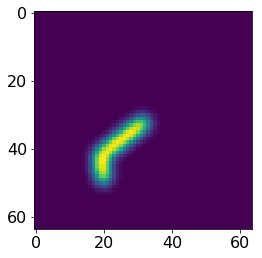

In [18]:
imshow(train_images_x[0][0])

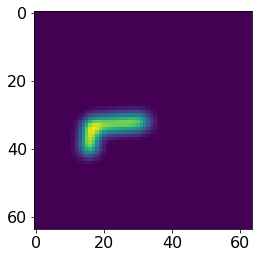

In [19]:
imshow(train_images_y[0][0])

## Factorized Gated Field Auto-encoder

Avant le passge dans l'autoencodeur, les images sont factorisées en passant par une couche de percpetron. De même, la couche latente est factorisée.
Les images sont de taille (128,128), on prend pour commencer 32 neurones. 
La sortie est de taille (3,1) (trois moteurs), on prend pour commencer une factorisation de taille (32,1) (synérgies motrices).

On a donc un encodeur, un décodeur et 3 couches de perceptrons pour les deux images et pour les commandes motrices.

On commence par construire un auto encodeur dont les entrées sont un tenseur de taille (32,1) et de sortie (32,1), pour garder la symétrie de la structure.


Dans cette version, la multiplication n'est pas une multiplication terme à terme mais un produit tensoriel des deux représentations utilisés dans l'autoencodeur.

### Création de l'encodeur 

In [20]:
input_size = 128
latent_dim = 64 # plus facile pour la concaténation des outputs...

# on donne en entrée des pairs d'images
inputs_xy = Input(shape = (2, img_size, img_size, ), name = 'xy')

# on sépare chacune des images
x = Lambda(lambda x: x[:,0,:,:])(inputs_xy)
x = Reshape((1,img_size, img_size,))(x)

y = Lambda(lambda x: x[:,1,:,:])(inputs_xy)
y = Reshape((1,img_size, img_size,))(y)

# on factorise chacune des images
fx = Flatten()(x)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx1')(fx)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx2')(fx)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx3')(fx)
fx = Reshape((latent_dim,1,))(fx)

fy = Flatten()(y)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy1')(fy)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy2')(fy)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy3')(fy)
fy = Reshape((1,latent_dim,))(fy)


# on multiplie les deux factorisations, avec produit tensoriel
matmul = Multiply()([fx, fy])

# on passe le tout dans une couche de perceptrons pour obtenir les synérgies motrices
x = Flatten()(matmul)
fh = Dense(latent_dim, name = 'latent_fh1')(x)
fh = Dense(latent_dim, name = 'latent_fh2')(x)
fh = Dense(latent_dim, name = 'latent_fh3')(x)
fh = Dense(latent_dim, name = 'latent_fh4')(x)
fh = Reshape((latent_dim,))(fh)

# tricks pour pouvoir passer fx et latent en outputs
fx = Reshape((1,latent_dim,))(fx)
fh = Reshape((1,latent_dim,))(fh)
print(K.int_shape(fx))
print(K.int_shape(fh))
#latent = Reshape((1,3,))(latent)

out = Concatenate()([fx, fh])

encoder = Model(inputs = inputs_xy, outputs = out, name = 'encoder')

Instructions for updating:
Colocations handled automatically by placer.
(None, 1, 64)
(None, 1, 64)


### Création du décodeur

In [21]:
latent_inputs = Input(shape = (1,2*latent_dim,), name = 'decoder_input')

# on déballe la factorisation en x
fxdec = Lambda(lambda x: x[:,:,:latent_dim])(latent_inputs)
fxdec = Reshape((latent_dim,1,))(fxdec)

# on déballe les synérgies motrices
inp = Lambda(lambda x: x[:,:,latent_dim:])(latent_inputs)
inp = Reshape((latent_dim,))(inp)

# on fait passer les synérgies motrices dans la couche de perceptrons
fhdec = Dense(latent_dim, name='latent_fhdec1')(inp)
fhdec = Dense(latent_dim, name='latent_fhdec2')(fhdec)
fhdec = Dense(latent_dim, name='latent_fhdec3')(fhdec)

fhdec = Reshape((1,latent_dim,))(fhdec)

# on mutliplie les deux représentations
matmuldec = Multiply()([fxdec, fhdec])
matmuldec = Flatten()(matmuldec)

# on en déduit une factorisation 
fydec = Dense(latent_dim, name = 'latent_fydec1')(matmuldec)
fydec = Dense(latent_dim, name = 'latent_fydec2')(fydec)
fydec = Dense(latent_dim, name = 'latent_fydec3')(fydec)
# on déduit l'image de départ de cette factorisation
ydec = Dense(img_size*img_size, activation = 'relu', name = 'y_recon')(fydec)
ydec = Reshape((1,img_size, img_size,))(ydec)
print(K.int_shape(ydec))

decoder = Model(inputs = latent_inputs, outputs= ydec, name='decoder')

(None, 1, 64, 64)


### Création de l'auto-encodeur

In [22]:
autoencoder = Model(inputs_xy, decoder(encoder(inputs_xy)), name = "autoencoder")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xy (InputLayer)              (None, 2, 64, 64)         0         
_________________________________________________________________
encoder (Model)              (None, 1, 128)            803264    
_________________________________________________________________
decoder (Model)              (None, 1, 64, 64)         549248    
Total params: 1,352,512
Trainable params: 1,352,512
Non-trainable params: 0
_________________________________________________________________


On enregistre des figures.

In [23]:
plot_model(encoder, to_file='figures_autoencoder/encoder_matmul.png')
plot_model(decoder, to_file = 'figures_autoencoder/decoder_matul.png')
plot_model(autoencoder, to_file = 'figures_autoencoder/auto_encoder_matmul.png')

## Entraînement de l'autoencodeur

On entraîne le modèle sur des pairs d'images.
On utilise une descente de gradient stochastique. 
edit: la descente de gradient stochastique n'est pas adapté ici.
adam fonctionne bien mieux.

In [24]:
autoencoder.compile(loss = 'mse', 
                    optimizer = 'adam', 
                    metrics = ['kullback_leibler_divergence', 'acc'])

history = autoencoder.fit(train_features,
                          train_images_y,
                          validation_split = 0.2,
                          epochs = 10)

Instructions for updating:
Use tf.cast instead.
Train on 9600 samples, validate on 2400 samples
Epoch 1/10
9600/9600 [==============================] - 9s 970us/step - loss: 3.3936e-04 - kullback_leibler_divergence: 0.7308 - acc: 0.3459 - val_loss: 1.4030e-04 - val_kullback_leibler_divergence: 0.4758 - val_acc: 0.6405
Epoch 2/10
9600/9600 [==============================] - 9s 904us/step - loss: 1.0405e-04 - kullback_leibler_divergence: 0.4072 - acc: 0.6775 - val_loss: 8.7311e-05 - val_kullback_leibler_divergence: 0.3697 - val_acc: 0.6434
Epoch 3/10
9600/9600 [==============================] - 9s 888us/step - loss: 6.6860e-05 - kullback_leibler_divergence: 0.3391 - acc: 0.7303 - val_loss: 6.0576e-05 - val_kullback_leibler_divergence: 0.3254 - val_acc: 0.7558
Epoch 4/10
9600/9600 [==============================] - 9s 908us/step - loss: 5.0216e-05 - kullback_leibler_divergence: 0.2977 - acc: 0.7786 - val_loss: 4.6055e-05 - val_kullback_leibler_divergence: 0.2860 - val_acc: 0.7951
Epoch 5/

### Visualisation

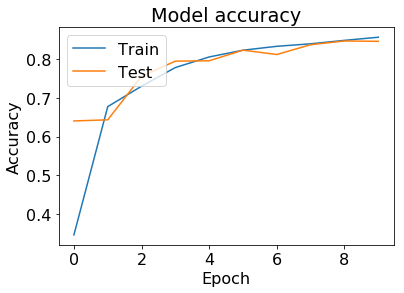

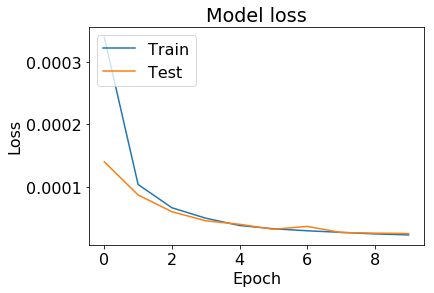

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Décodage

Image reconstruite

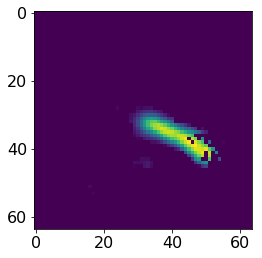

In [26]:
x_decoded = autoencoder.predict(train_features)
imshow(x_decoded[50][0])
#imgs = concatenate([x_decoded[50][0],train_images_y[50][0], train_images_x[50][0] ])
#Image.fromarray(imgs).save('exmple_recontr.png')

Image original

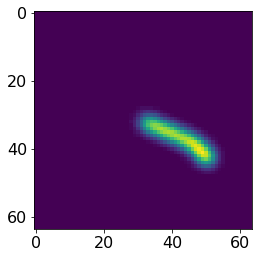

In [27]:
imshow(train_images_y[50][0])

Image donnée en entrée de l'autoencodeur

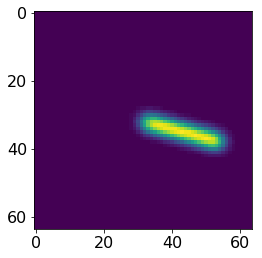

In [28]:
imshow(train_images_x[50][0])

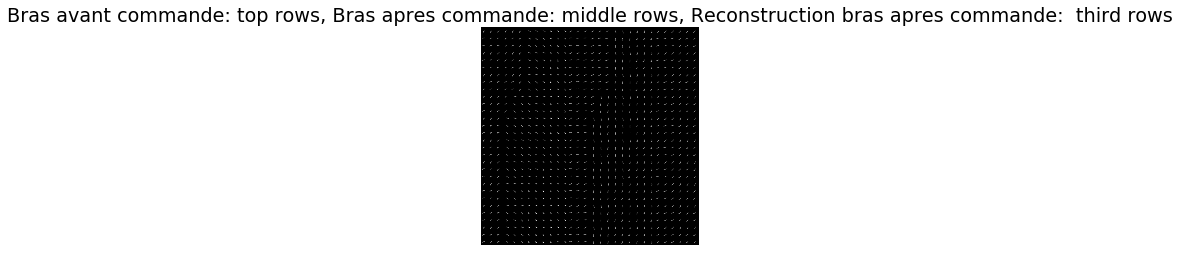

In [29]:

rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([train_images_x[:num], train_images_y[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, img_size, img_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, img_size, img_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs *255 ).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Bras avant commande: top rows, '
          'Bras apres commande: middle rows, '
          'Reconstruction bras apres commande:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('reconstruction_body_image.png')
plt.show()


### Couches intermédiaires

In [30]:

model = encoder  # create the original model

layer_name = 'latent_fh4'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(train_features)



Les synérgies motrices.

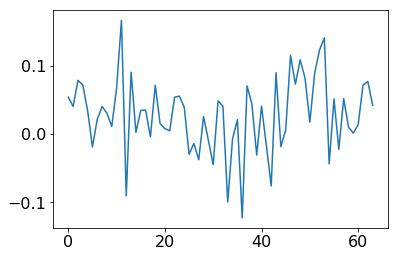

In [31]:
plt.plot(intermediate_output[0])

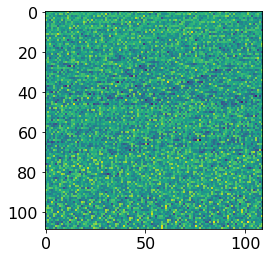

In [32]:
imshow(resize(intermediate_output, (109,109)))

In [33]:
shape(intermediate_output)

(12000, 64)

### Enregistrement du modèle